In [1]:
import pandas as pd
import numpy as np
import os
from typing import List
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
# Set the style of seaborn
sns.set_theme(style="whitegrid")
# Set the default figure size
plt.rcParams["figure.figsize"] = (10, 6)
# Set the default font size
plt.rcParams["font.size"] = 12
# Set the default color palette
sns.set_palette("deep")
# Ensure no dataframe output is truncated
pd.set_option("display.max_columns", 1)
# Ensure no column is truncated
pd.set_option("display.max_colwidth", 1)


# Utils for data processing
# TODO: Load files from a given path and append all of them into a single dataframe
def load_files(path):
    all_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".csv"):
                all_files.append(os.path.join(root, file))
    return all_files


def get_data(path: List[str] | str) -> pd.DataFrame:
    """Loads all data files in a directory or a single file into a pandas DataFrame.
    Args:
        path (str or list of str): Path to the directory or a single file.
    Returns:
        pd.DataFrame: DataFrame containing all data. (If list was passed, it will be concatenated)
    """
    unified_df = []
    if isinstance(path, str):
        if os.path.isdir(path):
            all_files = load_files(path)
            for file in all_files:
                df = pd.read_csv(file, parse_dates=["Date"])
                unified_df.append(df)
        else:
            df = pd.read_csv(path)
    elif isinstance(path, list):
        for file in path:
            df = pd.read_csv(file)
            unified_df.append(df)
    else:
        raise ValueError("Path must be a string or a list of strings.")
    if len(unified_df) > 0:
        df = pd.concat(unified_df, ignore_index=True)
    else:
        df = pd.DataFrame()
    # Remove duplicate rows
    df = df.drop_duplicates()
    # Remove rows with all NaN values
    df = df.dropna(how='all')
    return df

# Show the first few rows of the dataframe
def show_data(df):
    print("Displaying a few facts about the dataframe: \n", "="*50)
    print("First few rows of the dataframe:")
    print("-"*50)
    display(df.head())
    print("Data types:")
    print("-"*50)
    display(df.dtypes)
    print("Dataset description and statistics: ")
    print("-"*50)
    display(df.describe())
    print("Missing values:")
    print("-"*50)
    display(df.isnull().sum())
    print("Shape of the dataframe:")
    print("-"*50)
    print(df.shape)
    print("Columns:")
    print("-"*50)
    print(df.columns)

# Paths to the datasets
DATA_DIR = "../data"

INDICES = os.path.join(DATA_DIR, "train/indices")
for root, dirs, files in os.walk(INDICES):
    for file in files:
        print(os.path.join(root, file))

../data/train/indices/Dow_Jones.csv
../data/train/indices/NASDAQ.csv
../data/train/indices/SP500.csv


In [2]:
all_files = load_files(INDICES)
print(f"Found {len(all_files)} files in {INDICES}")

Found 3 files in ../data/train/indices


In [3]:
# Load the data
df = get_data(INDICES)
show_data(df)

Displaying a few facts about the dataframe: 
First few rows of the dataframe:
--------------------------------------------------


,Date,...
0,2015-01-02,...
1,2015-01-05,...
2,2015-01-06,...
3,2015-01-07,...
4,2015-01-08,...


Data types:
--------------------------------------------------


Date        datetime64[ns]
Ticker      object        
Open        float64       
High        float64       
Low         float64       
Close       float64       
Adjusted    float64       
Returns     float64       
Volume      int64         
dtype: object

Dataset description and statistics: 
--------------------------------------------------


,Date,...
count,7710,...
mean,2020-02-09 01:23:29.182879488,...
min,2015-01-02 00:00:00,...
25%,2017-07-21 00:00:00,...
50%,2020-02-10 12:00:00,...
75%,2022-08-29 00:00:00,...
max,2025-03-21 00:00:00,...
std,NaN,...


Missing values:
--------------------------------------------------


Date        0
Ticker      0
Open        0
High        0
Low         0
Close       0
Adjusted    0
Returns     3
Volume      0
dtype: int64

Shape of the dataframe:
--------------------------------------------------
(7710, 9)
Columns:
--------------------------------------------------
Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adjusted', 'Returns',
       'Volume'],
      dtype='object')


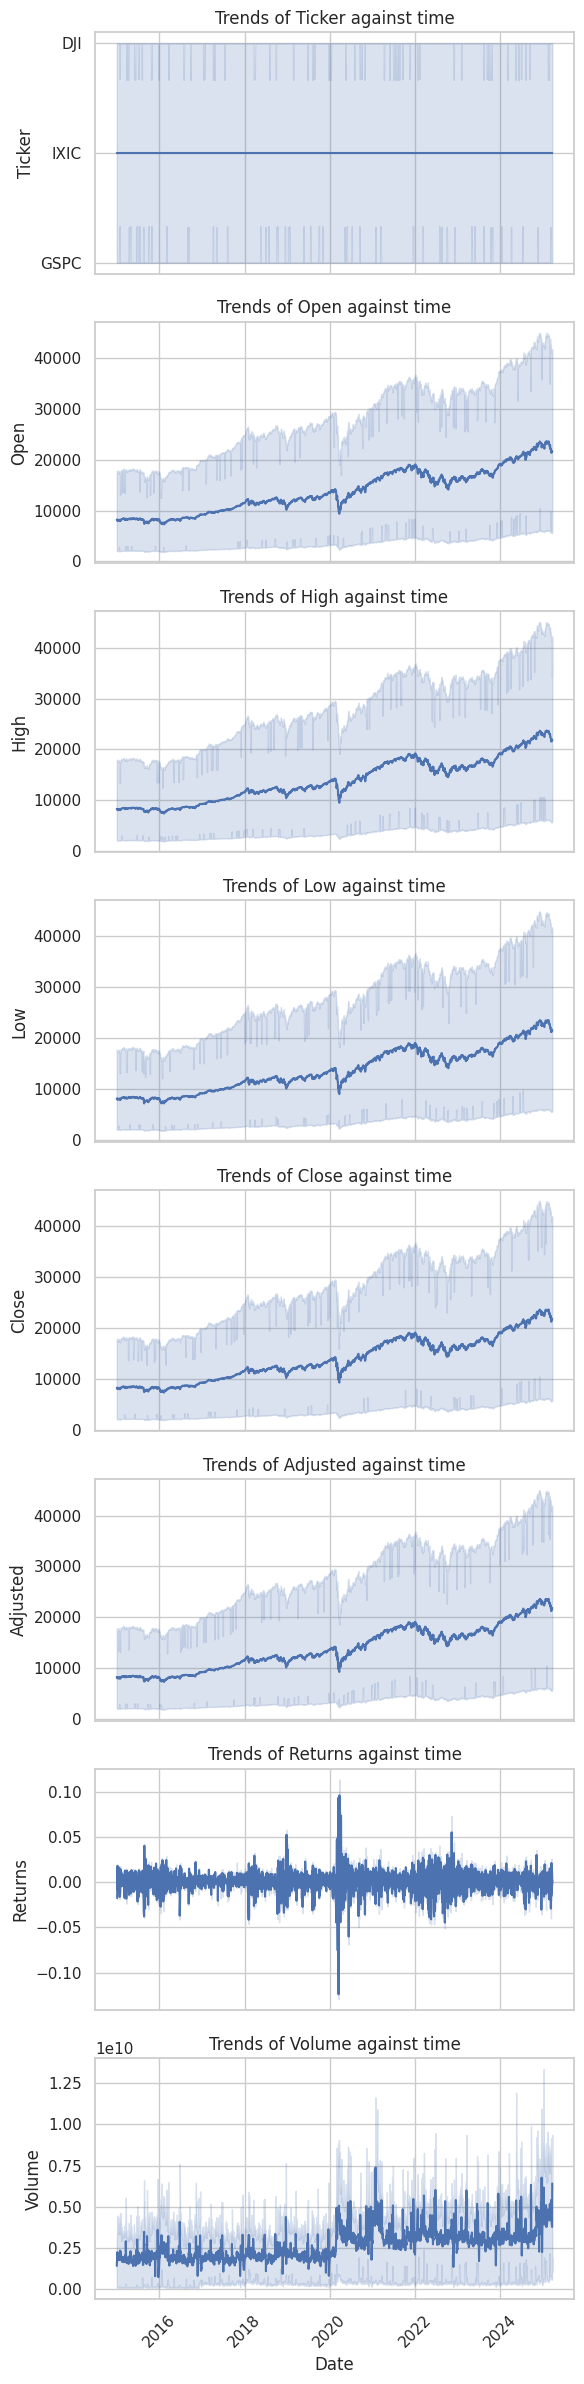

In [4]:
# Refined function to visualize trends against time for each of the columns
def plot_trends(df: pd.DataFrame, columns: List[str]):
    """Plots the trends of multiple columns against time in subplots.
    Args:
        df (pd.DataFrame): DataFrame containing the data.
        columns (List[str]): List of column names to plot.
    """
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(6, 3 * num_columns), sharex=True)
    
    if num_columns == 1:
        axes = [axes]  # Ensure axes is iterable for a single column
    
    for ax, column in zip(axes, columns):
        sns.lineplot(data=df, x='Date', y=column, ax=ax)
        ax.set_title(f'Trends of {column} against time')
        ax.set_xlabel('Date')
        ax.set_ylabel(column)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Convert 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
# Plot trends for all columns
columns_to_plot = [col for col in df.columns if col != 'Date']  # Exclude 'Date' column
plot_trends(df.reset_index(), columns_to_plot)

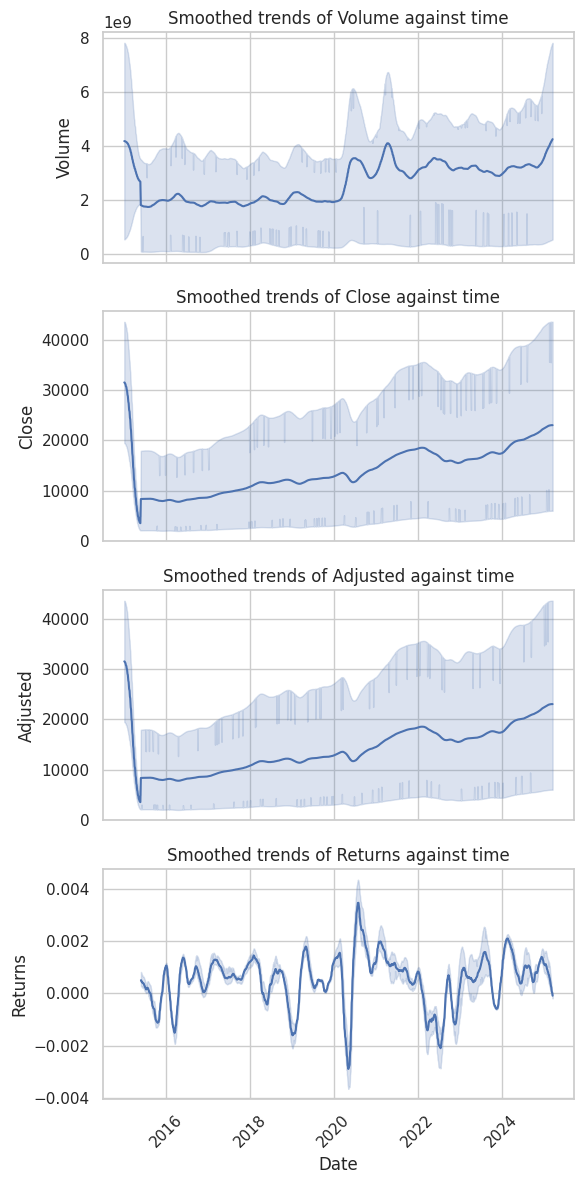

In [5]:
# TODO: Smooth the trend for Volume, close, adjusted and returns to see the trend better
WINDOW = 50
def smooth_trend(df: pd.DataFrame, column: str, window: int) -> pd.Series:
    """Smooths the trend of a given column using a rolling mean.
    Args:
        df (pd.DataFrame): DataFrame containing the data.
        column (str): Column name to smooth.
        window (int): Window size for the rolling mean.
    Returns:
        pd.Series: Smoothed series.
    """
    return df[f"{column}"].rolling(window=window).mean()

# Plot smoothed trends for Volume, Close, Adjusted and Returns
def plot_smoothed_trends(df: pd.DataFrame, columns: List[str], window: int):
    """Plots the smoothed trends of multiple columns against time in subplots.
    Args:
        df (pd.DataFrame): DataFrame containing the data.
        columns (List[str]): List of column names to plot.
        window (int): Window size for the rolling mean.
    """
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(6, 3 * num_columns), sharex=True)
    
    if num_columns == 1:
        axes = [axes]  # Ensure axes is iterable for a single column
    
    for ax, column in zip(axes, columns):
        smoothed_series = smooth_trend(df, column, window)
        sns.lineplot(data=df, x='Date', y=smoothed_series, ax=ax)
        ax.set_title(f'Smoothed trends of {column} against time')
        ax.set_xlabel('Date')
        ax.set_ylabel(column)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

columns_plot = ['Volume', 'Close', 'Adjusted', 'Returns']
for column in columns_plot:
    df[f"{column}"] = smooth_trend(df, column, WINDOW)

plot_smoothed_trends(df.reset_index(), columns_plot, WINDOW)

In [6]:
df["Ticker"].nunique()

3

In [7]:
df.head()

,Date,...
0,2015-01-02,...
1,2015-01-05,...
2,2015-01-06,...
3,2015-01-07,...
4,2015-01-08,...


In [8]:
df.isna().sum()

Date        0  
Ticker      0  
Open        0  
High        0  
Low         0  
Close       49 
Adjusted    49 
Returns     150
Volume      49 
dtype: int64

In [9]:
df.describe()

,Date,...
count,7710,...
mean,2020-02-09 01:23:29.182879488,...
min,2015-01-02 00:00:00,...
25%,2017-07-21 00:00:00,...
50%,2020-02-10 12:00:00,...
75%,2022-08-29 00:00:00,...
max,2025-03-21 00:00:00,...
std,NaN,...


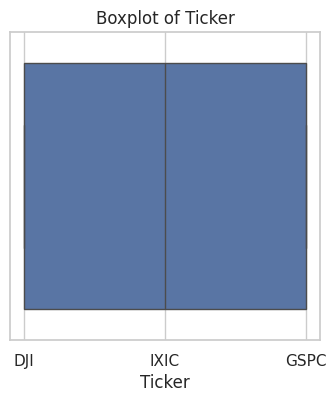

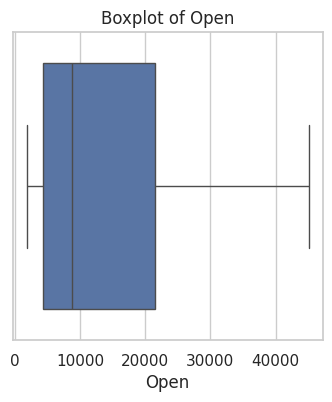

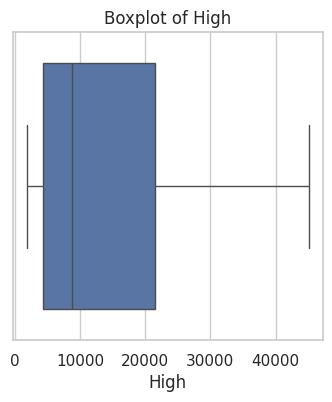

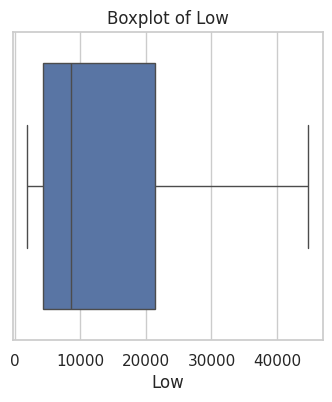

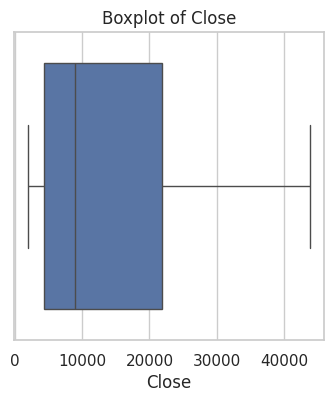

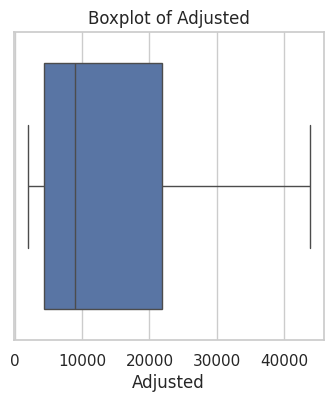

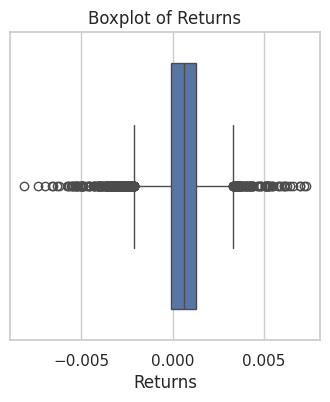

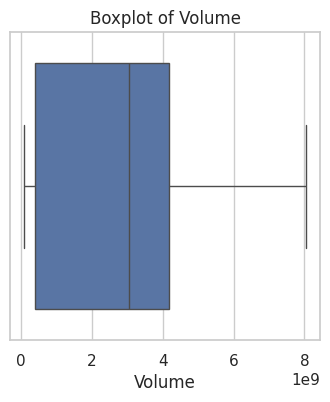

In [10]:
# TODO: Inspect the dataset to find outliers
def plot_boxplot(df: pd.DataFrame, column: str):
    """Plots a boxplot for a given column.
    Args:
        df (pd.DataFrame): DataFrame containing the data.
        column (str): Column name to plot.
    """
    plt.figure(figsize=(4, 4))
    sns.boxplot(data=df, x=column)
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

# Plot boxplots for all columns
columns_to_plot = [col for col in df.columns if col != 'Date']  # Exclude 'Date' column
for column in columns_to_plot:
    plot_boxplot(df, column)

In [11]:
# TODO: Fill missing values using the forward strategy
df = df.ffill()
print(df.isna().sum())
df.describe()

Date        0 
Ticker      0 
Open        0 
High        0 
Low         0 
Close       49
Adjusted    49
Returns     50
Volume      49
dtype: int64


,Date,...
count,7710,...
mean,2020-02-09 01:23:29.182879488,...
min,2015-01-02 00:00:00,...
25%,2017-07-21 00:00:00,...
50%,2020-02-10 12:00:00,...
75%,2022-08-29 00:00:00,...
max,2025-03-21 00:00:00,...
std,NaN,...


In [12]:
df.dropna(inplace=True)
print(df.isna().sum())

Date        0
Ticker      0
Open        0
High        0
Low         0
Close       0
Adjusted    0
Returns     0
Volume      0
dtype: int64


In [13]:
# TODO: Create a prophet model
from prophet import Prophet

/home/dan/anaconda3/envs/stock/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [15]:
features = ['Open', 'High', 'Low', 'Close', 'Adjusted', 'Returns']
model = Prophet()
train =df.copy()

train = train.rename(columns={'Date': 'ds', 'Volume': 'y'})

for feature in features:
    model.add_regressor(feature)

model.fit(train)

21:16:11 - cmdstanpy - INFO - Chain [1] start processing
21:16:24 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Predict next 30 days – include your own forecast or assumption of feature values
future_dates = pd.date_range(start=train['ds'].max() + pd.Timedelta(days=1), periods=30)
future = pd.DataFrame({'ds': future_dates})

# Add feature columns with default or assumed values
for feature in features:
	future[feature] = df[feature].mean()  # Replace with your own assumptions if needed

forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

           ds  ...
0  2025-03-22  ...
1  2025-03-23  ...
2  2025-03-24  ...
3  2025-03-25  ...
4  2025-03-26  ...
5  2025-03-27  ...
6  2025-03-28  ...
7  2025-03-29  ...
8  2025-03-30  ...
9  2025-03-31  ...
10 2025-04-01  ...
11 2025-04-02  ...
12 2025-04-03  ...
13 2025-04-04  ...
14 2025-04-05  ...
15 2025-04-06  ...
16 2025-04-07  ...
17 2025-04-08  ...
18 2025-04-09  ...
19 2025-04-10  ...
20 2025-04-11  ...
21 2025-04-12  ...
22 2025-04-13  ...
23 2025-04-14  ...
24 2025-04-15  ...
25 2025-04-16  ...
26 2025-04-17  ...
27 2025-04-18  ...
28 2025-04-19  ...
29 2025-04-20  ...

[30 rows x 4 columns]


In [19]:
forecast.head()

,ds,...
0,2025-03-22,...
1,2025-03-23,...
2,2025-03-24,...
3,2025-03-25,...
4,2025-03-26,...


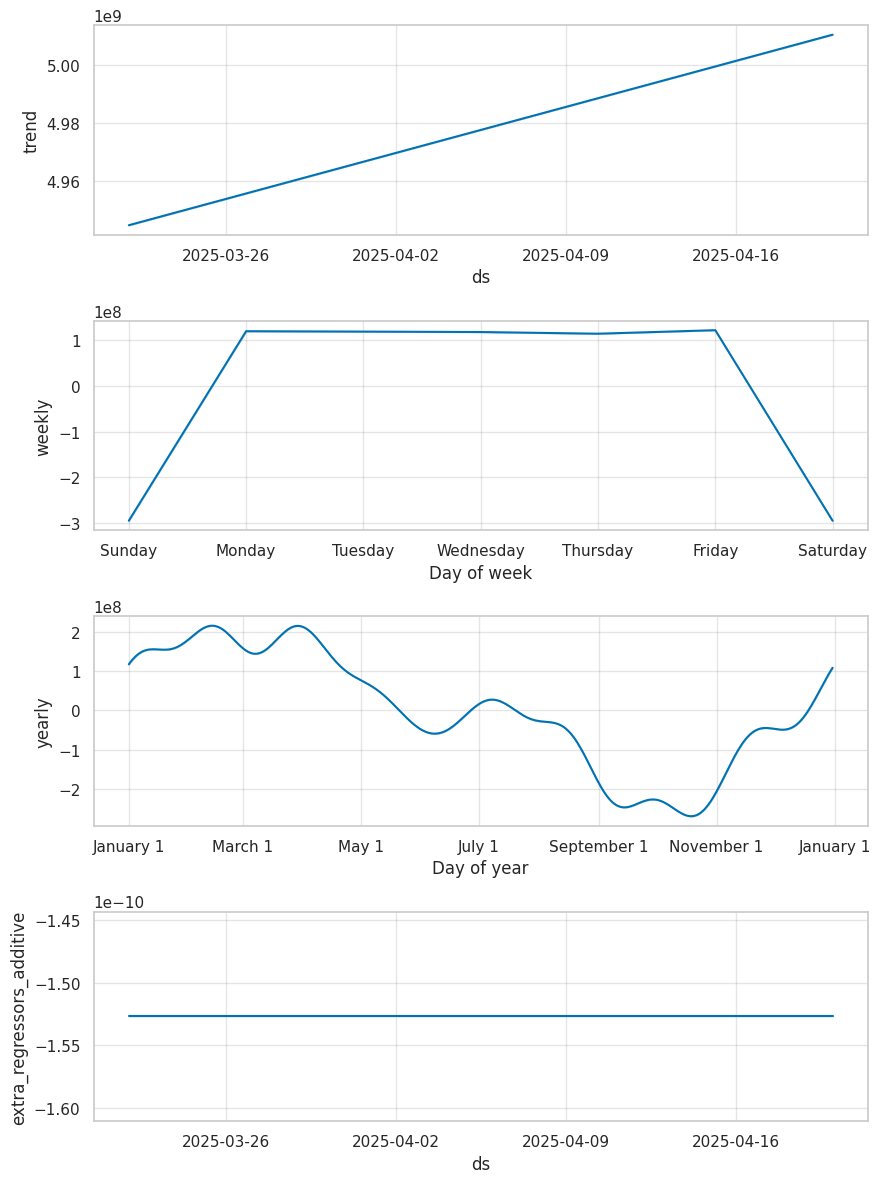

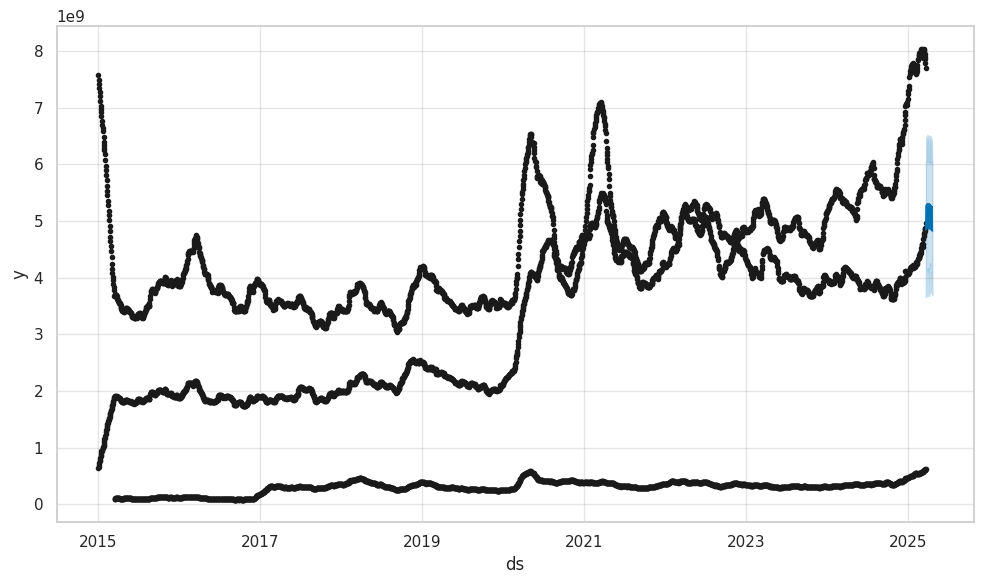

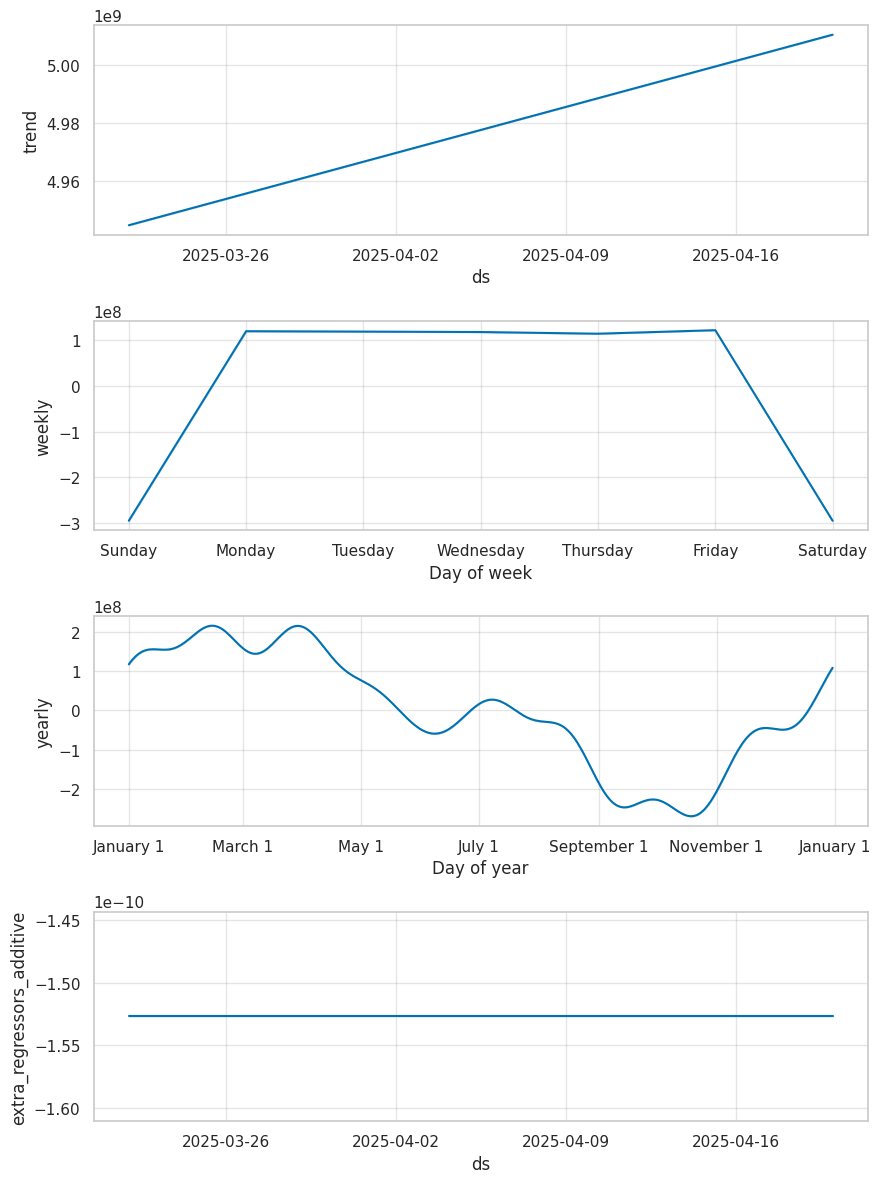

In [20]:
model.plot(forecast)
model.plot_components(forecast)